In [1]:
# The notebook contantains methodes for bin files reading and visualizing (IMU data)

In [55]:
from struct import *
import pandas as pd
import os.path as path
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile
from os.path import join

In [35]:
def load_data(file_name, sense_type, debug_out = True):
    # sense_type: 'ACR', 'ACN', 'GYR', 'GYN', 'HUN', 'BAN', 'HTN', 'PTN', 'BTN'
    # If sense_type is in ['ACR', 'ACN', 'GYR', 'GYN'] then x, y, and z component are available and sense_type has 
    # additional last symbol 'C', otherwise the last symbol is 'N'. For example, 'ACRC' or 'BTNN'
    # The data field's mask is: 'SENSE_TYPE[s]'+'C[s]'+'x_value[f]'+'y_value[f]'+'z_value[f]'+'Time[f]' 
    # or 'SENSE_TYPE[s]'+'N[s]'+'value[f]'+'Time[f]'.

    # open and read data
    f = open(file_name, 'rb')
    data = f.read()
    f.close()
    
    
    # parse data fields
    position = 0
    counter = 0
    fields_found = {}
    triple_fields = ['ACRC', 'ACNC', 'GYRC', 'GYNC']
    single_fields = ['HUNN', 'BANN', 'HTNN', 'PTNN', 'BTNN', 'IMAG']

    
    
    if sense_type + 'C' in triple_fields:
        columns = ['x', 'y', 'z', 'time']
    elif sense_type + 'N' in single_fields or sense_type == 'IMAG':
        columns = ['value', 'time']
    else:
        print 'Your provided sense type is not recognized!'
        return None
    
    value_series = []
    
    while len(data) > 0:
        if position + 4 > len (data):
            break
            
        data_pos = data[position:position + 4]
        if data_pos in triple_fields:               
            # read triple component
            if data_pos[:-1] == sense_type:
                unpack_data = data[position + 4: position + 4 + 12 + 8]
                values = unpack('<fffd', unpack_data)
                value_series.append(values)
                counter += 1
            
        elif data_pos in single_fields:
            # read single component
            if data_pos[:-1] == sense_type and sense_type != 'IMAG':
                unpack_data = data[position + 4: position + 4 + 4 + 8]
                values = unpack('<fd', unpack_data)
                value_series.append(values)
                counter += 1
            elif sense_type == 'IMAG' and data_pos == sense_type:
                unpack_data = data[position + 4: position + 4 + 4 + 8]
                values = unpack('<Id', unpack_data)
                value_series.append(values)
                counter += 1                
        
        # count data fields
        if (data_pos in triple_fields) or (data_pos in single_fields):
            if fields_found.has_key(data_pos):
                fields_found[data_pos] = fields_found[data_pos] + 1
            else:
                fields_found[data_pos] = 1
                
        # shift reading position
        position += 1
    
    data_series = pd.DataFrame(value_series, columns=columns)
    
    # get detected fields info
    if debug_out:
        for key in fields_found.keys():
            print "For {:s} readed {:d} records".format(key[:-1], fields_found[key])
    
    return data_series


In [62]:
def load_from_all_dumps(dump_dir, sense_type):
    # loads the sense type from all dump files in the dump_dir
    
    # list of dumpfiles and sort them in increasing order
    files_tup = [(join(dump_dir,file_name), int(file_name[5:11])) for file_name in listdir(dump_dir) \
                 if isfile(join(dump_dir, file_name)) and file_name[-3:] == 'bin']
    
    print "Files found:", len(files_tup)
    if len(files_tup) == 0:
        print "Files not found in {:s}".format(dump_dir)
        return None
    
    # sort list for tuples
    files_tup.sort(key=lambda tup:tup[1])
    
    # process the each dump file
    dataset = None
    for file_name, file_id in files_tup:
        if dataset is None:
            dataset = load_data(file_name, sense_type)
        else:
            new_part = load_data(file_name, sense_type, debug_out=False)
            dataset = pd.concat([dataset, new_part])
    
    return dataset

In [21]:
sense_data = load_data('/home/sholc/optic_env/sources/hdeer/dump_3_30.08.2017/dump_000004.bin', 'HTN')
print sense_data.shape
print sense_data.tail(10)


For BTN readed 6 records
For GYR readed 12477 records
For HUN readed 6 records
For IMA readed 28 records
For ACR readed 12477 records
For HTN readed 6 records
(6, 2)
       value          time
0  37.455605  1.504106e+09
1  37.346035  1.504107e+09
2  37.437344  1.504107e+09
3  37.437344  1.504107e+09
4  37.455605  1.504107e+09
5  37.400818  1.504107e+09


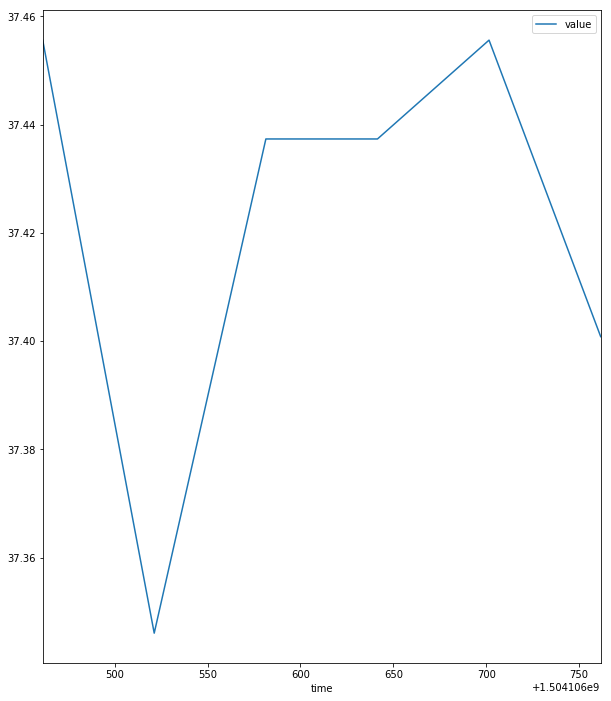

In [22]:
sense_data.plot(kind='line', x=['time'], y=['value'], figsize=(10, 12))

In [63]:
data_full= load_from_all_dumps('/home/sholc/optic_env/sources/hdeer/dump_3_30.08.2017', 'ACR')


Files found: 49
For BTN readed 7 records
For GYR readed 12477 records
For HUN readed 7 records
For IMA readed 28 records
For ACR readed 12474 records
For HTN readed 7 records


In [64]:
print data_full.shape

(611349, 4)


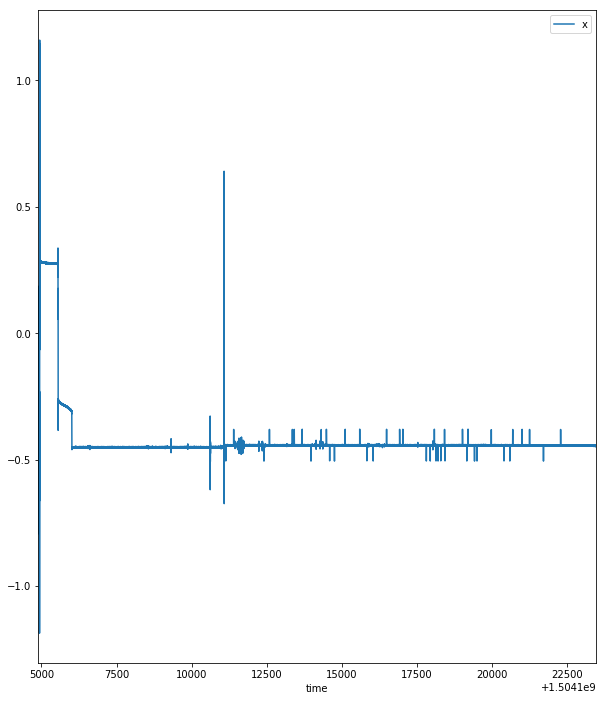

In [65]:
data_full.plot(kind='line', x=['time'], y=['x'], figsize=(10, 12))